In [1]:
%pylab inline
import seaborn as sns
from scipy import signal

figsize(14,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def spectrum(a, Fs=4000, db=False):
    f = np.fft.rfftfreq(a.shape[0], d=1./Fs)
    
    if db == True:
        
        A = 20*np.log10(np.abs(np.fft.rfft(a))/float(a.shape[0]))
        
        plot(f, np.maximum(A,-300))
    else:
        plot(f, np.abs(np.fft.rfft(a)/a.shape[0]))
        
    margin = 0.05 * Fs/2
    xlim((f[0]-margin, f[-1]+margin))

def spec_comp(a, b, titles=['1','2'], Fs=4000, db=False):
    figure()
    subplot(1,2,1)
    spectrum(a, Fs=Fs, db=db)
    title(titles[0])

    subplot(1,2,2)
    spectrum(b,Fs=Fs, db=db)
    title(titles[1])

In [3]:
class SecondOrderSection:
    
    def __init__(self, b, a, extra_bits=2):
        
        # Q15
        self.b = np.array(b, dtype=np.int16)
        self.a = np.array(a, dtype=np.int16)
        # Q10+extra_bits
        self.extra_bits = extra_bits
        self.zx = np.zeros(2, dtype=np.int32)
        self.zy = np.zeros(2, dtype=np.int32)
        
    def process(self, x):
        
        
        x = np.left_shift(np.array(x, dtype=np.int32), self.extra_bits)
        
        # Q(15+10+extra_bits)
        y = 2*x*self.b[0] + 2*self.zx[0]*self.b[1] + self.zx[1]*self.b[2] \
            + 2*self.zy[0]*self.a[1] + self.zy[1]*self.a[2]
        
        self.zx[1] = self.zx[0]
        self.zx[0] = x
        self.zy[1] = self.zy[0]
        self.zy[0] = np.right_shift(y, 15)
        
        return np.right_shift(self.zy[0], self.extra_bits)
  

class NotchDC:
    
    def __init__(self, alpha, extra_bits=2):
        
        # Q15
        self.alpha = np.array(alpha, dtype=np.int16)
        # Q10 + extra_bits
        self.extra_bits = extra_bits
        self.zx = np.array(0, dtype=np.int32)
        self.zy = np.array(0, dtype=np.int32)
        
    def process(self, x):
        
        x = np.left_shift(np.array(x, dtype=np.int32), self.extra_bits)
        
        y = x - self.zx + np.right_shift(self.alpha*self.zy, 15)
        
        self.zx = x
        self.zy = y
        
        return np.right_shift(y, self.extra_bits)
    
class LeakyAverage:
    
    def __init__(self, alpha, Q=17, extra_bits=2):
        
        self.Q = Q
        self.alpha = np.array(2**self.Q*alpha, dtype=np.int32)
        self.one_m_alpha = np.array(2**self.Q-self.alpha, dtype=np.int32)
        
        # Q10 + extra_bits
        self.extra_bits = extra_bits
        self.zy = np.array(0, dtype=np.int32)
        
    def process(self, x):
        
        # Q12
        x = np.left_shift(np.array(x, dtype=np.int32), self.extra_bits)
        
        # Q12 * Q15 = Q27
        y = np.right_shift(self.one_m_alpha*x + self.alpha*self.zy, self.Q)

        self.zy = y
        
        return np.right_shift(y, self.extra_bits)

512.44008


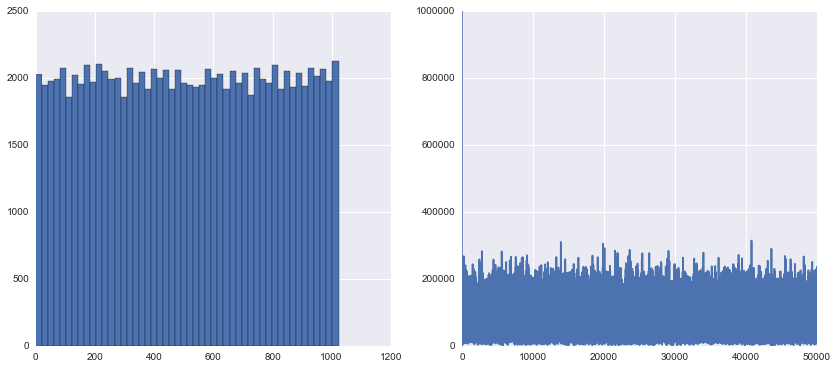

In [4]:
x = np.array(np.random.choice(1024, size=(100000)), dtype=np.int16)

subplot(1,2,1)
hist(x, bins=50)

subplot(1,2,2)
plot(np.abs(np.fft.rfft(x)))
ylim((0,1000000))

print np.mean(x)

499.66913


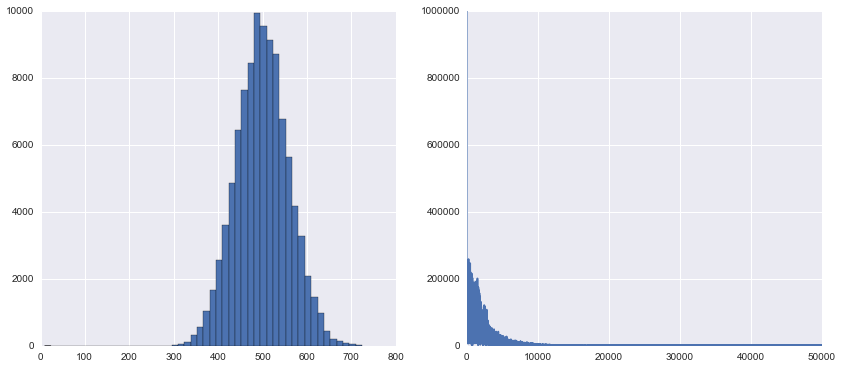

In [5]:
stage1 = SecondOrderSection(np.array([0xca, 0xff3a, 0x195]), np.array([0x0000, 0x7579, 0x936f]))
y = np.empty_like(x)
for i in xrange(y.shape[0]):
    y[i] = stage1.process(x[i])
    
subplot(1,2,1)
hist(y, bins=50)

subplot(1,2,2)
plot(np.abs(np.fft.rfft(y)))
ylim((0,1000000))
print np.mean(y)

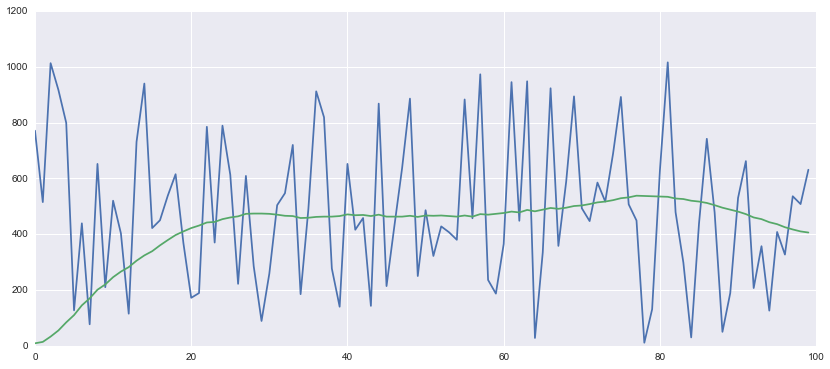

In [6]:
plot(x[0:100])
plot(y[0:100])

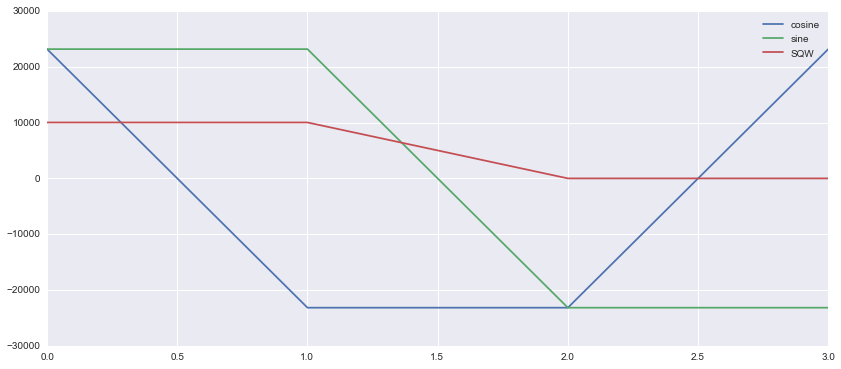

In [33]:
M = 4
cosine = np.array((2**15)*np.cos(2*np.pi*(np.arange(M)+0.5)/M), dtype=np.int16)
sine = np.array((2**15)*np.sin(2*np.pi*(np.arange(M)+0.5)/M), dtype=np.int16)
sqw = np.ones(sine.shape, dtype=np.int16)
sqw[M/2:] = 0
plot(cosine)
plot(sine)
plot(10024*sqw)
plt.legend(['cosine','sine','SQW'])

# create long signal vectors
L = 100000/M

cosine_L = np.tile(cosine, (L))
sine_L = np.tile(sine, (L))
sqw_L = np.tile(sqw, (L))

before moving average 2818.55392
after moving average 2818.13622


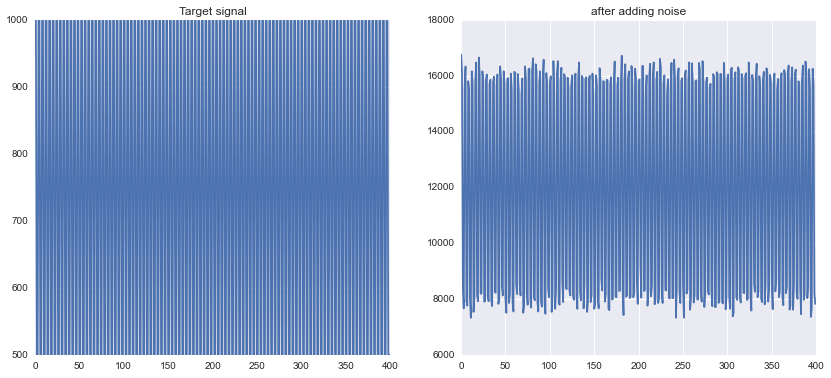

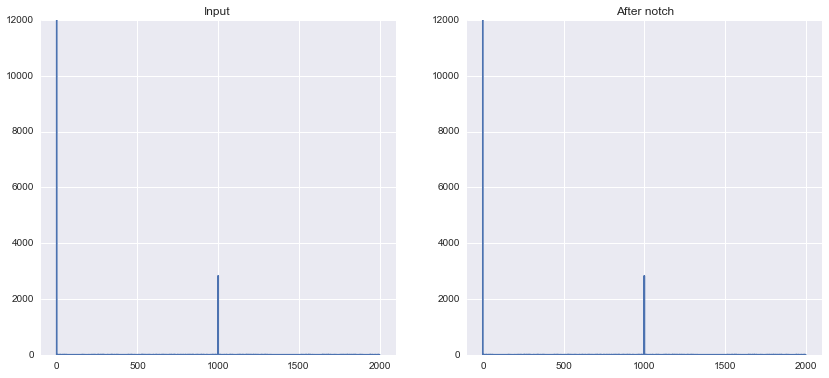

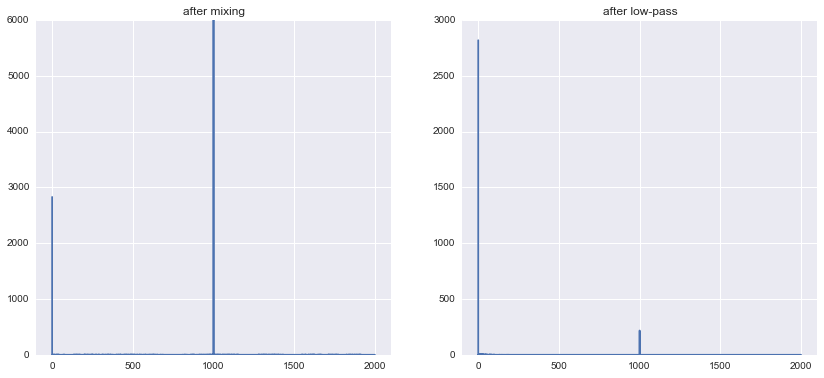

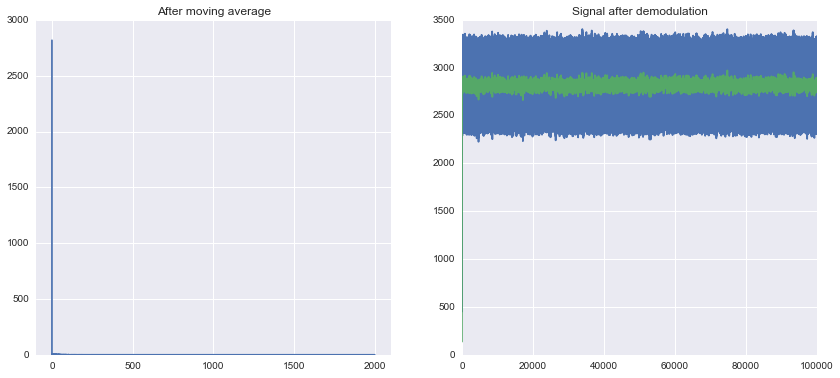

In [34]:
# add DC to test
A = 500 # amplitude
C = 500 # DC
sigma_n = 20

notch_filter_flag = False

sqw_DC = A*sqw_L + C

db_flag = False
plot_chunk = -400
filter_extra_bits = 0
signal_extra_bits = 4

figure()
subplot(1,2,1)
plot(sqw_DC[plot_chunk:])
title('Target signal')

noise = np.array(np.random.normal(size=sqw_L.shape)*sigma_n, dtype=np.int16)
sqw_DC += noise

# give two extra bits
sqw_DC = np.left_shift(sqw_DC, signal_extra_bits)

subplot(1,2,2)
plot(sqw_DC[plot_chunk:])
title('after adding noise')

sqw_notch = sqw_DC

# plot the spectrum before and after notch filter
spec_comp(sqw_DC, sqw_notch, titles=['Input','After notch'], db=db_flag)

# Mix down the signal
product = np.array(sine_L, dtype=np.int32) * sqw_notch
product = np.right_shift(product, 15)
    
# Use leaky average to recover the DC component
leaky_avg = LeakyAverage(0.95, Q=15, extra_bits=filter_extra_bits)
b = np.empty_like(product)
for i in xrange(b.shape[0]):
    b[i] = leaky_avg.process(product[i])


# compare spectrum of product signal to low-pass signal
spec_comp(product, b, titles=['after mixing','after low-pass'], db=db_flag)

# Apply a moving average to remove the harmonics of the original square wave
L_ma = M
num = np.ones(L_ma)
c = np.array(signal.lfilter(num, [1], b), dtype=np.int16)/L_ma

figure()
subplot(1,2,1)
spectrum(c, db=db_flag)
title('After moving average')

subplot(1,2,2)
plot(b[:])
plot(c[:])
title('Signal after demodulation')

print 'before moving average',b.mean()
print 'after moving average',c.mean()

In [35]:
print [uint16(s) for s in sine]

[23170, 23170, 42366, 42366]


In [28]:
0x7ff0/2.**15

0.99951171875